## Health Survey Risk Factors
source: https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso,Ridge,ElasticNet
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB  # Naive Bayes classifiers
from scipy.stats import chi2_contingency,f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve,learning_curve

In [132]:
df=pd.read_csv('/Users/aliceqichaowu/Desktop/38615/FinalProject/brfss2013/brfss2013_new1.csv',low_memory=False)
df.head()

,genhlth,physhlth,menthlth,hlthpln1,persdoc2,medcost,checkup1,sleptim1,bphigh4,bloodcho,...,fc60_,strfreq_,pamiss1_,X_pastrng,X_lmtact1,X_lmtwrk1,X_lmtscl1,X_rfseat2,X_rfseat3,X_age80
0,Good,0.0,0.0,Yes,"Yes, only one",No,Within past year,6.0,No,Yes,...,506.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,50.0
1,Good,3.0,2.0,Yes,"Yes, only one",No,Within past year,9.0,No,Yes,...,474.0,0.0,0.0,Did not meet muscle strengthening recommendations,Told have arthritis and have limited usual act...,Told have arthritis and have limited work,Told have arthritis and social activities limi...,Always or almost always wear seat belt,Always wear seat belt,55.0
2,Very good,2.0,0.0,Yes,"Yes, only one",No,Within past 2 years,8.0,No,Yes,...,417.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,64.0
3,Good,10.0,2.0,Yes,"Yes, only one",No,5 or more years ago,6.0,Yes,Yes,...,406.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,66.0
4,Very good,0.0,0.0,Yes,"Yes, only one",No,Within past year,8.0,Yes,Yes,...,512.0,0.0,0.0,Did not meet muscle strengthening recommendations,Not told they have arthritis,Not told they have arthritis,Not told they have arthritis,Always or almost always wear seat belt,Always wear seat belt,49.0


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339282 entries, 0 to 339281
Columns: 124 entries, genhlth to X_age80
dtypes: float64(39), int64(1), object(84)
memory usage: 321.0+ MB


In [134]:
for i in range(len(df.columns)):
    if df.columns[i]=='genhlth':
        print('the index of the general health column:', i)

the index of the general health column: 0


In [5]:
## select columns with general health and other predictors
df=df.iloc[:,18:]


In [10]:
## Check missing values
# print('There are %i nan in the dataframe' % df.isna().sum().sum())
df.isnull().sum()/df.shape[0]

genhlth      0.0
physhlth     0.0
menthlth     0.0
hlthpln1     0.0
persdoc2     0.0
            ... 
X_lmtwrk1    0.0
X_lmtscl1    0.0
X_rfseat2    0.0
X_rfseat3    0.0
X_age80      0.0
Length: 124, dtype: float64

In [89]:
## find out how many columns have missing values < 10% data pts for each column
## 0.1: 0.69; 0.15: 0.491; 0.2: 0.42;
mask=df.isnull().sum()/df.shape[0]<0.1
features=df.columns[mask]
df1=df[features]
print('Percentage of columns remained: ', len(features)/len(df.columns))

Percentage of columns remained:  1.0


In [57]:
rows_remain=len(df1[df1.isnull().any(axis=1)])/len(df1)
print('Percentage of rows remained after removing missing values: ',rows_remain )

Percentage of rows remained after removing missing values:  0.3100869299984749


In [58]:
df1.dropna(inplace=True)
df1.reset_index(drop=True,inplace=True)

<ipython-input-58-0f76be566f0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


In [61]:
df1.tail()
df1.shape


(339282, 124)

In [135]:
## drop useless columns
df=df.drop(columns=['X_misfrtn','X_misvegn','X_frtresp','X_vegresp'])

In [41]:
import os  
os.makedirs('/Users/aliceqichaowu/Desktop/38615/brfss2013/', exist_ok=True)  
df.to_csv('/Users/aliceqichaowu/Desktop/38615/brfss2013/brfss2013_new1.csv',index=False)  


## Transform categorical data

In [125]:
features = pd.read_csv('/Users/aliceqichaowu/Desktop/38615/FinalProject/features.txt', sep=' ',header=None)
feat_lst=features.iloc[:,0].values.tolist()

In [126]:

df_cat=df.select_dtypes(include='object')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num=df.select_dtypes(include=numerics)

In [127]:
df_cat['genhlth'].replace(['Excellent','Very good','Good','Fair','Poor'],
                        [1,2,3,4,5], inplace=True)
# df_cat['genhlth'].replace(['Excellent','Good','Poor'],
#                         [0,1,2], inplace=True)

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [128]:
for i in range(1,df_cat.shape[1]):
    col_name=df_cat.columns[i]
    df_cat[col_name]=df_cat[col_name].astype('category').cat.codes

<ipython-input-128-a66fc8f2acf2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col_name]=df_cat[col_name].astype('category').cat.codes


In [129]:
df_new=df_cat.join(df_num)

In [130]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()       
        df = df[(df[col] <= mean+(n_std*sd))]       
    return df

df_out=remove_outliers(df_new,df_new.columns,8)

print(df_out.shape)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
df_cat_new=df_out.iloc[:,:80].astype('category')
df1=df_cat_new.join(df_out.iloc[:,80:])

In [ ]:
corr_matrix=df_out.iloc[:,1:].corr()
corr_matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.99)]
print('There are '+str(len(to_drop))+' variables are highly correlated')

In [20]:
df1

,genhlth,hlthpln1,persdoc2,medcost,checkup1,bphigh4,bloodcho,cvdinfr4,cvdcrhd4,cvdstrk3,...,grenday_,orngday_,vegeda1_,X_frutsum,X_vegesum,maxvo2_,fc60_,strfreq_,pamiss1_,X_age80
0,3,1,2,0,4,0,1,0,0,0,...,43.0,29.0,43.0,20.0,148.0,2950.0,506.0,0.0,0.0,50.0
1,3,1,2,0,4,0,1,0,0,0,...,29.0,33.0,100.0,46.0,191.0,2765.0,474.0,0.0,0.0,55.0
2,2,1,2,0,2,0,1,0,0,0,...,33.0,17.0,57.0,49.0,136.0,2432.0,417.0,0.0,0.0,64.0
3,3,1,2,0,0,2,1,0,0,0,...,33.0,10.0,100.0,7.0,243.0,2370.0,406.0,0.0,0.0,66.0
4,2,1,2,0,4,2,1,0,0,0,...,43.0,0.0,100.0,157.0,143.0,2987.0,512.0,0.0,0.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339277,3,1,2,0,4,0,1,0,0,0,...,43.0,14.0,71.0,0.0,228.0,2395.0,411.0,0.0,0.0,65.0
339278,3,1,2,0,0,2,1,0,0,0,...,50.0,71.0,100.0,94.0,292.0,3415.0,585.0,0.0,0.0,47.0
339279,4,1,0,0,4,2,1,1,1,0,...,100.0,29.0,100.0,107.0,329.0,2654.0,455.0,0.0,0.0,58.0
339280,4,1,0,1,4,0,1,0,0,0,...,13.0,43.0,71.0,500.0,127.0,3431.0,588.0,0.0,0.0,37.0


In [29]:
cat_sig=[]
for i in range(1,df_cat.shape[1]):
    crosstab=pd.crosstab(index=df_cat['genhlth'],columns=df_cat.iloc[:,i])
    chiq=chi2_contingency(crosstab)
    cat_sig.append(chiq[1])
    print('p-value',df_cat.columns[i],chiq[1])

p-value hlthpln1 7.3261814159059e-310
p-value persdoc2 0.0
p-value medcost 0.0
p-value checkup1 0.0
p-value bphigh4 0.0
p-value bloodcho 2.3512491047301367e-161
p-value cvdinfr4 0.0
p-value cvdcrhd4 0.0
p-value cvdstrk3 0.0
p-value asthma3 0.0
p-value chcscncr 3.464363603703956e-111
p-value chcocncr 0.0
p-value chccopd1 0.0
p-value havarth3 0.0
p-value addepev2 0.0
p-value chckidny 0.0
p-value diabete3 0.0
p-value veteran3 2.1361371702551086e-108
p-value marital 0.0
p-value educa 0.0
p-value employ1 0.0
p-value internet 0.0
p-value renthom1 0.0
p-value sex 4.75011352308668e-53
p-value qlactlm2 0.0
p-value useequip 0.0
p-value blind 0.0
p-value decide 0.0
p-value diffwalk 0.0
p-value diffdres 0.0
p-value diffalon 0.0
p-value smoke100 0.0
p-value usenow3 6.378762322063607e-11
p-value exerany2 0.0
p-value seatbelt 0.0
p-value flushot6 6.839993150296172e-142
p-value qstver 0.0
p-value qstlang 0.0
p-value X_imprace 0.0
p-value X_dualuse 0.0
p-value X_rfhlth 0.0
p-value X_rfhype5 0.0
p-value

In [30]:
num_sig=[]
df_anova=df_num.join(df_cat['genhlth'])
for i in range(df_anova.shape[1]-1):
    catgroup=df_anova.groupby('genhlth')[df_anova.columns[i]].apply(list)
    anova=f_oneway(*catgroup)
    num_sig.append(anova[1])
    print('p-value for ANOVA is: ', df_anova.columns[i],anova[1])

p-value for ANOVA is:  physhlth 0.0
p-value for ANOVA is:  menthlth 0.0
p-value for ANOVA is:  sleptim1 0.0
p-value for ANOVA is:  children 0.0
p-value for ANOVA is:  weight2 1.6381925491151653e-94
p-value for ANOVA is:  height3 7.175533431499361e-251
p-value for ANOVA is:  alcday5 0.0
p-value for ANOVA is:  fruitju1 2.628697080911036e-144
p-value for ANOVA is:  fruit1 7.457622556608531e-236
p-value for ANOVA is:  fvbeans 1.4483490760348645e-200
p-value for ANOVA is:  fvgreen 1.7286649013914995e-140
p-value for ANOVA is:  fvorang 9.752725902795133e-170
p-value for ANOVA is:  vegetab1 4.718642612157395e-195
p-value for ANOVA is:  strength 0.0
p-value for ANOVA is:  X_ststr 4.803445589620612e-28
p-value for ANOVA is:  X_strwt 2.278160535554775e-66
p-value for ANOVA is:  X_rawrake 4.697061146335783e-71
p-value for ANOVA is:  X_wt2rake 3.130420434784829e-75
p-value for ANOVA is:  X_llcpwt2 1.1515691111842374e-45
p-value for ANOVA is:  X_llcpwt 1.1267807168875824e-31
p-value for ANOVA is:  

In [38]:
[i>0.05 for i in cat_sig]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [60]:
features = pd.read_csv('/Users/aliceqichaowu/Desktop/38615/FinalProject/features.txt', sep=' ',header=None)
feat_lst=features.iloc[:,0].values.tolist()

In [71]:
# y = df1['genhlth']
# X = df1.iloc[:,1:]
y = df1['genhlth']
X = df1[feat_lst]
X

,X_lmtwrk1,X_prace1,diffalon,employ1,diffwalk,alcday5,exerany2,chcocncr,X_frtlt1,useequip,...,X_ageg5yr,X_age80,renthom1,X_race_g1,X_racegr3,X_ststr,X_rfdrhv4,pamiss1_,marital,chcscncr
0,0,7,0,2,0,0.0,1,0,0,0,...,6,50.0,1,4,4,11081.0,0,0.0,2,0
1,1,7,0,2,1,220.0,0,0,0,0,...,7,55.0,1,4,4,11081.0,1,0.0,2,0
2,0,7,0,5,0,208.0,1,0,0,0,...,8,64.0,1,4,4,11081.0,0,0.0,2,0
3,0,7,0,5,0,210.0,0,1,0,0,...,9,66.0,1,4,4,11082.0,0,0.0,2,0
4,0,2,0,2,0,0.0,1,0,1,0,...,5,49.0,1,0,0,11081.0,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339277,2,7,0,0,0,0.0,0,0,0,0,...,9,65.0,1,1,1,722019.0,0,0.0,2,0
339278,0,7,0,2,1,204.0,1,0,0,1,...,5,47.0,1,1,1,722019.0,0,0.0,2,0
339279,2,7,1,0,1,0.0,0,0,1,0,...,7,58.0,1,1,1,722019.0,0,0.0,1,0
339280,0,6,0,2,0,0.0,1,0,1,0,...,3,37.0,1,1,1,722019.0,0,0.0,0,0


In [62]:
y.value_counts()

2    116994
3     99299
1     62398
4     39994
5     15300
Name: genhlth, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


NameError: name 'X' is not defined

In [82]:
# Normalization
scaler = StandardScaler()  # normalization: zero mean, unit variance
scaler.fit(X_train)  # scaling factor determined from the training set

X_train = scaler.transform(X_train)
scaler.fit(X_test) 
X_test = scaler.transform(X_test)


In [24]:
## feature selection
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included


In [65]:
included= forward_regression(X,y,0.05,verbose=True)

<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_lmtwrk1                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_prace1                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  diffalon                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  employ1                        with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  diffwalk                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  alcday5                        with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  exerany2                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  chcocncr                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_frtlt1                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  useequip                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_vegesum                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_drdxar1                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_fruitex                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  cvdinfr4                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bphigh4                        with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfbmi5                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfhlth                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  decide                         with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfsmok3                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_bmi5                         with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  qlactlm2                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_totinda                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_pastrng                      with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  diabete3                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  havarth3                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  physhlth                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  internet                       with p-value 0.0


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  medcost                        with p-value 1.04026e-264


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  menthlth                       with p-value 1.25772e-147


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  chccopd1                       with p-value 1.63838e-122


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_hispanc                      with p-value 4.21256e-95


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_smoker3                      with p-value 7.55734e-95


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  drocdy3_                       with p-value 1.85639e-89


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  cvdcrhd4                       with p-value 8.956e-83


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_drnkmo4                      with p-value 1.0979e-59


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grenday_                       with p-value 1.21957e-51


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_asthms1                      with p-value 3.82798e-48


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_dualuse                      with p-value 4.63941e-48


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  addepev2                       with p-value 1.59124e-43


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  educa                          with p-value 1.26324e-44


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  frutda1_                       with p-value 4.23004e-43


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sleptim1                       with p-value 1.36028e-38


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfseat3                      with p-value 3.2034e-34


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfhype5                      with p-value 5.19695e-33


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  hlthpln1                       with p-value 3.07442e-32


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  strength                       with p-value 2.08909e-27


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_cholchk                      with p-value 4.77533e-26


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sex                            with p-value 2.69852e-21


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  fc60_                          with p-value 1.43702e-33


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_age_g                        with p-value 4.84166e-62


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_educag                       with p-value 4.90379e-21


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  persdoc2                       with p-value 3.61422e-19


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  children                       with p-value 1.32283e-17


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  cvdstrk3                       with p-value 3.12582e-17


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  chckidny                       with p-value 3.28262e-15


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  qstlang                        with p-value 3.18574e-15


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  strfreq_                       with p-value 2.05417e-13


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  htin4                          with p-value 1.01018e-12


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  wtkg3                          with p-value 4.68113e-54


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  drnkany5                       with p-value 5.55301e-12


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfbing5                      with p-value 1.39102e-11


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  flushot6                       with p-value 2.87945e-11


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  veteran3                       with p-value 1.07708e-11


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_lmtscl1                      with p-value 3.27657e-10


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_raceg21                      with p-value 1.08364e-09


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfseat2                      with p-value 2.96889e-09


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_age65yr                      with p-value 1.42141e-06


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  checkup1                       with p-value 6.0054e-06


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  beanday_                       with p-value 1.09458e-05


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rawrake                      with p-value 4.82908e-05


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  seatbelt                       with p-value 0.000117151


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_ageg5yr                      with p-value 0.000224167


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_age80                        with p-value 2.4213e-06


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  renthom1                       with p-value 0.000456698


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_race_g1                      with p-value 0.0010697


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_racegr3                      with p-value 0.0010697


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_ststr                        with p-value 0.00135308


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  X_rfdrhv4                      with p-value 0.00657312


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  pamiss1_                       with p-value 0.0232147


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  marital                        with p-value 0.0273482


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  chcscncr                       with p-value 0.0355739


<ipython-input-63-039d06be3595>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [73]:
len(included)

81

In [75]:
with open('/Users/aliceqichaowu/Desktop/38615/brfss2013/features.txt', 'w') as fp:
    fp.write('\n'.join(included))

,X_lmtwrk1,X_prace1,diffalon,employ1,diffwalk,alcday5,exerany2,chcocncr,X_frtlt1,useequip,...,X_ageg5yr,X_age80,renthom1,X_race_g1,X_racegr3,X_ststr,X_rfdrhv4,pamiss1_,marital,chcscncr
0,0,7,0,2,0,0.0,1,0,0,0,...,6,50.0,1,4,4,11081.0,0,0.0,2,0
1,1,7,0,2,1,220.0,0,0,0,0,...,7,55.0,1,4,4,11081.0,1,0.0,2,0
2,0,7,0,5,0,208.0,1,0,0,0,...,8,64.0,1,4,4,11081.0,0,0.0,2,0
3,0,7,0,5,0,210.0,0,1,0,0,...,9,66.0,1,4,4,11082.0,0,0.0,2,0
4,0,2,0,2,0,0.0,1,0,1,0,...,5,49.0,1,0,0,11081.0,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339277,2,7,0,0,0,0.0,0,0,0,0,...,9,65.0,1,1,1,722019.0,0,0.0,2,0
339278,0,7,0,2,1,204.0,1,0,0,1,...,5,47.0,1,1,1,722019.0,0,0.0,2,0
339279,2,7,1,0,1,0.0,0,0,1,0,...,7,58.0,1,1,1,722019.0,0,0.0,1,0
339280,0,6,0,2,0,0.0,1,0,1,0,...,3,37.0,1,1,1,722019.0,0,0.0,0,0


In [60]:
## linear
X_const= sm.add_constant(X_train)
model1 = sm.OLS(y_train, X_const).fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                genhlth   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     4457.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:23:43   Log-Likelihood:            -2.5850e+05
No. Observations:              267188   AIC:                         5.172e+05
Df Residuals:                  267079   BIC:                         5.184e+05
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4860      0.001   2017.503      0.000       2.484       2.488
x1            -0.0152      0.001    -10.765      0.000      -0.018      -0.012
x2            -0.0117      0.001     -9.179      0.000      -0.014      -0.009
x3             0.0279      0.001     19.955      0.000       0.025       0.031
x4             0.0054      0.001      3.790      0.000       0.003       0.008
x5             0.0246      0.005      5.427      0.000       0.016       0.033
x6             0.0027      0.003      0.918      0.358      -0.003       0.008
x7             0.0126      0.001      8.771      0.000       0.010       0.015
x8             0.0209      0.001     14.525      0.000       0.018       0.024
x9             0.0100      0.001      7.735      0.000       0.007       0.012
x10         5.843e+09   1.43e+10      0.407      0.684   -2.23e+10     3.4e+10
x11            0.0027      0.001      2.066      0.039       0.000       0.005
x12            0.0378      0.001     29.504      0.000       0.035       0.040
x13            0.0202      0.001     14.733      0.000       0.018       0.023
x14         1.716e+10   8.38e+09      2.048      0.041    7.38e+08    3.36e+10
x15            0.0218      0.001     15.257      0.000       0.019       0.025
x16            0.0092      0.001      7.245      0.000       0.007       0.012
x17            0.0424      0.001     31.561      0.000       0.040       0.045
x18           -0.0091      0.001     -6.271      0.000      -0.012      -0.006
x19            0.0024      0.001      1.762      0.078      -0.000       0.005
x20            0.0209      0.002     11.805      0.000       0.017       0.024
x21           -0.0087      0.001     -5.900      0.000      -0.012      -0.006
x22           -0.0334      0.001    -22.381      0.000      -0.036      -0.030
x23            0.0046      0.001      3.491      0.000       0.002       0.007
x24            0.0321      0.002     14.217      0.000       0.028       0.036
x25            0.0731      0.002     43.461      0.000       0.070       0.076
x26            0.0017      0.002      1.103      0.270      -0.001       0.005
x27            0.0008      0.001      0.603      0.547      -0.002       0.003
x28            0.0086      0.001      5.878      0.000       0.006       0.011
x29            0.0035      0.002      1.973      0.049    2.23e-05       0.007
x30           -0.0012      0.001     -0.820      0.412      -0.004       0.002
x31            0.0018      0.002      1.167      0.243      -0.001       0.005
x32            0.0026      0.004      0.678      0.498      -0.005       0.010
x33           -0.0015      0.001     -1.184      0.236      -0.004       0.001
x34         1.312e+08   6.96e+07      1.885      0.059    -5.2e+06    2.68e+08
x35            0.0095      0.004      2.489      0.013       0.002       0.017
x3

In [102]:
df3=df1[(df1['genhlth']== 1)|(df1['genhlth']== 3)|(df1['genhlth']== 5)]

y = df3['genhlth']
X = df3[feat_lst]


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
scaler = StandardScaler()  # normalization: zero mean, unit variance
scaler.fit(X_train)  # scaling factor determined from the training set

X_train = scaler.transform(X_train)
scaler.fit(X_test) 
X_test = scaler.transform(X_test)

In [83]:
## logistic
mdl_lr = LogisticRegression('l2')
mdl_lr.fit(X_train, y_train)
y_pred_LR = np.squeeze(mdl_lr.predict(X_test))

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [104]:
## xgboost
mdl_xgb = XGBClassifier()#booster='gblinear'
mdl_xgb.fit(X_train, y_train)
y_pred_xgb = np.squeeze(mdl_xgb.predict(X_test))


/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [85]:
## Logistic regression + Elastic net
mdl_lr2 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5)
mdl_lr2.fit(X_train, y_train)
y_pred_lr2 = np.squeeze(mdl_lr2.predict(X_test))


/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [110]:
# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = np.squeeze(rf.predict(X_test))
y_prob_rf = rf.predict_proba(X_test) 

In [106]:
# Evaluation metrics
# target_names = ['Excellent','Very good','Good','Fair','Poor']
target_names = ['Excellent','Good','Poor']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

              precision    recall  f1-score   support

   Excellent       0.74      0.68      0.71     12497
        Good       0.81      0.85      0.83     19759
        Poor       1.00      1.00      1.00      3144

    accuracy                           0.80     35400
   macro avg       0.85      0.84      0.85     35400
weighted avg       0.80      0.80      0.80     35400



In [111]:
target_names = ['Excellent','Good','Poor']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

   Excellent       0.75      0.65      0.70     12497
        Good       0.80      0.86      0.83     19759
        Poor       1.00      1.00      1.00      3144

    accuracy                           0.80     35400
   macro avg       0.85      0.84      0.84     35400
weighted avg       0.80      0.80      0.80     35400



In [122]:
train_sizes, train_scores, valid_scores = learning_curve(XGBClassifier(use_label_encoder=False), X, y, train_sizes=np.linspace(0.1, 1, 10), cv=5)

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-pac

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 903, in fit
    train_dmatrix, evals = self._wrap_evaluation_matrices(
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 265, in _wrap_evaluation_matrices
    train_dmatrix = DMatrix(data=X, label=y, weight=sample_weight,
  File "/Users/aliceqichaowu/opt/anacon

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 903, in fit
    train_dmatrix, evals = self._wrap_evaluation_matrices(
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 265, in _wrap_evaluation_matrices
    train_dmatrix = DMatrix(data=X, label=y, weight=sample_weight,
  File "/Users/aliceqichaowu/opt/anacon

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-pac

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-pac

/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aliceqichaowu/opt/anaconda3/lib/python3.8/site-pac

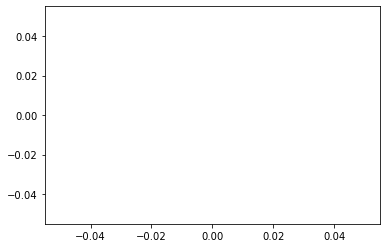

In [117]:
plt.plot(train_sizes, train_scores, markersize=5,color='green', label='Training Accuracy')